# Running BELLHOP Ray Tracing Model with TritonOA

This notebook shows two implementations of running the BELLHOP ray tracing propagation model. A convenient, high-level abstraction `runner` is shown, as well as the lower-level, object-based implementation. For most applications, the `runner` object will likely be most appropriate to use.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tritonoa.plotting import plot_SSP
from tritonoa.ssp import munk_ssp

## Using the `runner` interface

When using TritonOA with the `runner` interface, all of the model parameters are stored in a dictionary and passed to the runner function. This interface is a convenient method to run the model and obtain the ray traces.

In [2]:
from tritonoa.at.models.bellhop import runner

### Plotting the ray trace

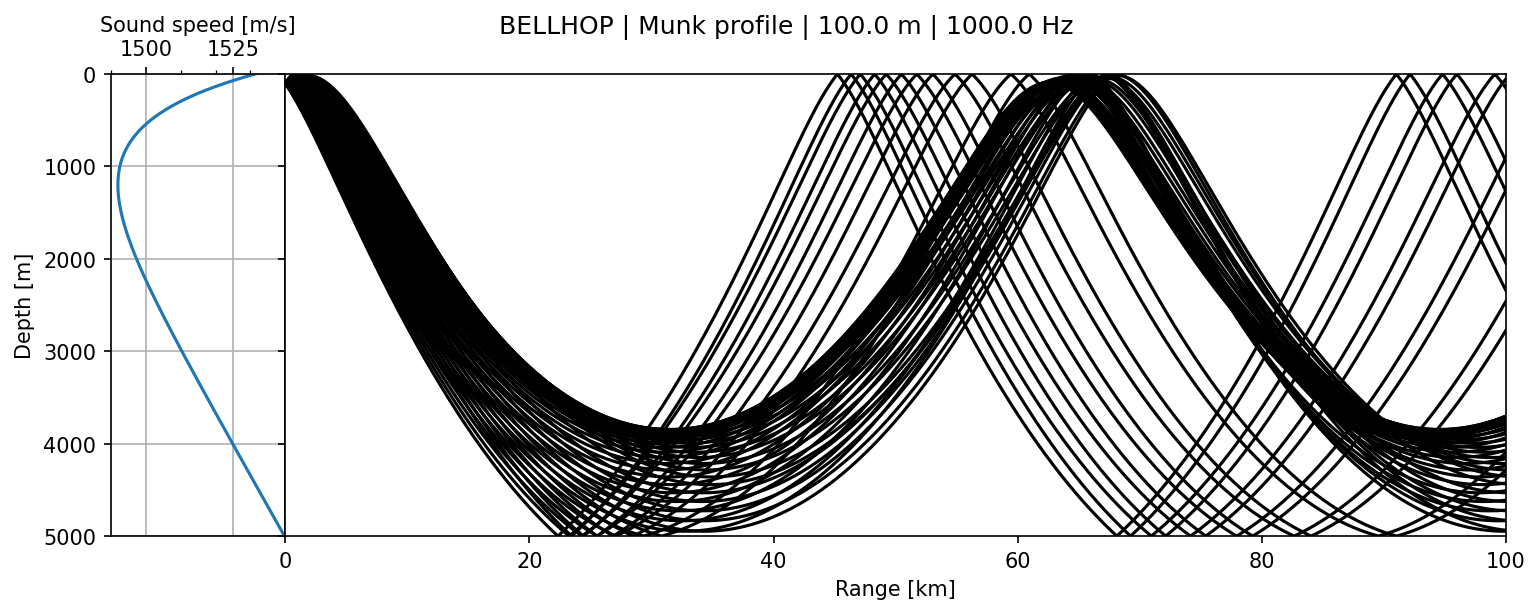

In [3]:
# Load SSP data
ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

# Define environment
environment = {
    # 1. General
    "title": "Munk",
    "model": "KRAKEN",
    # 2. Top medium (halfspace)
    # 3. Layered media
    "layerdata": [{"z": z_data, "c_p": c_data, "rho": 1.0}],
    # 4. Bottom medium
    "bot_opt": "A",
    "bot_c_p": 1600,
    "bot_rho": 1.8,
    "bot_a_p": 0.8,
    # 5. Receiver parameters
    "rec_z": 1000,
    "rec_r": 100,
    # 6. Source parameters
    "src_z": 100.0,
    "freq": 1000.0,
    # 7. Ray trace parameters
    "nbeams": 51,
    "zbox": max(z_data) + 3,
    "rbox": 101,
}

# Run BELLHOP
model = runner.run_bellhop(environment)
# Get ray traces
beams = model.beams

# Plot SSP and ray traces
fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 7], "wspace": 0},
    figsize=(12, 4),
    dpi=150,
    facecolor="w",
)
ax = plot_SSP(z_data, c_data, xlabel="Sound speed [m/s]", ylabel="Depth [m]", ax=axs[0])

ax = axs[1]
for ray in beams.sources[0]:
    ax.plot([r / 1000 for r in ray.r], ray.z, "k")
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_ylim(5000, 0)
ax.set_xlabel("Range [km]")
fig.suptitle(
    f"BELLHOP | {environment['title']} profile | {environment['src_z']} m | {environment['freq']} Hz"
)
plt.show()

### Plotting the eigenrays

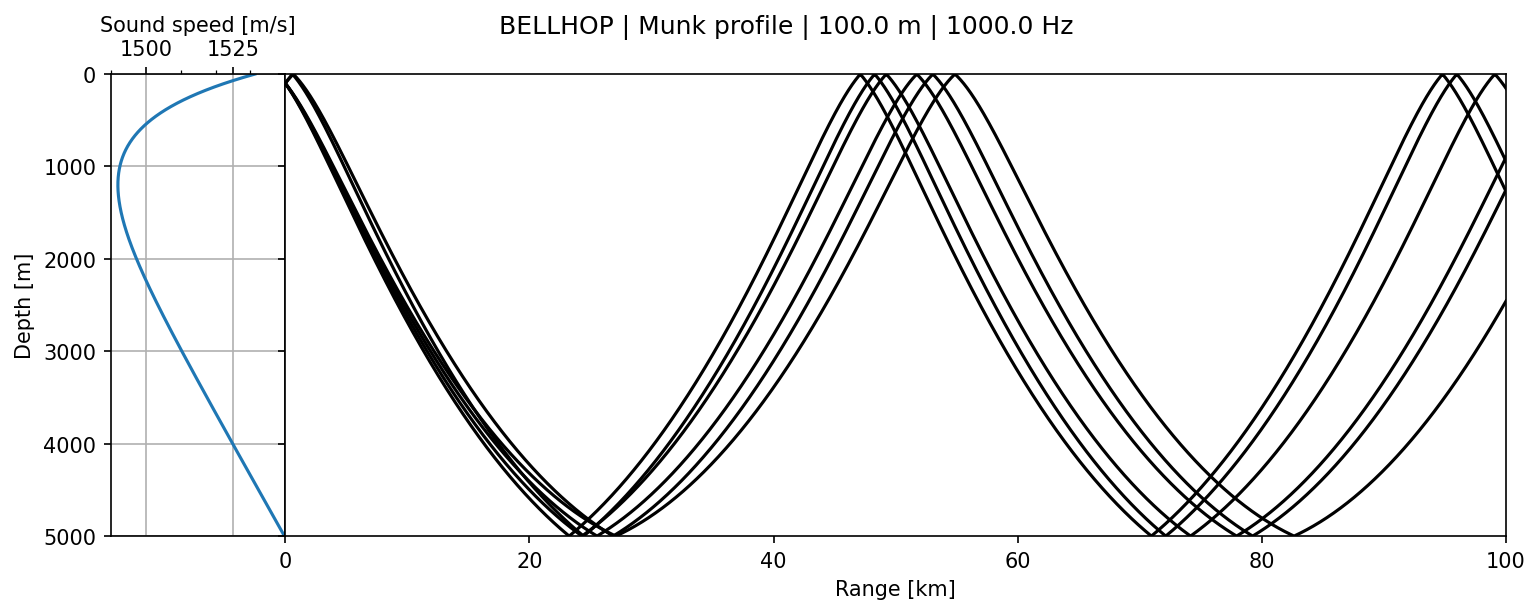

In [4]:
# Load SSP data
ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

# Define environment
environment = {
    # 1. General
    "title": "Munk",
    "model": "KRAKEN",
    # 2. Top medium (halfspace)
    # 3. Layered media
    "layerdata": [{"z": z_data, "c_p": c_data, "rho": 1.0}],
    # 4. Bottom medium
    "bot_opt": "A",
    "bot_c_p": 1600,
    "bot_rho": 1.8,
    "bot_a_p": 0.8,
    # 5. Receiver parameters
    "rec_z": 1000,
    "rec_r": 100,
    # 6. Source parameters
    "src_z": 100.0,
    "freq": 1000.0,
    # 7. Ray trace parameters
    "nbeams": 51,
    "zbox": max(z_data) + 3,
    "rbox": 101,
    "run_type": "E",
}

# Run BELLHOP
model = runner.run_bellhop(environment)
# Get ray traces
beams = model.beams

# Plot SSP and ray traces
fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 7], "wspace": 0},
    figsize=(12, 4),
    dpi=150,
    facecolor="w",
)
ax = plot_SSP(z_data, c_data, xlabel="Sound speed [m/s]", ylabel="Depth [m]", ax=axs[0])

ax = axs[1]
for ray in beams.sources[0]:
    ax.plot([r / 1000 for r in ray.r], ray.z, "k")
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_ylim(5000, 0)
ax.set_xlabel("Range [km]")
fig.suptitle(
    f"BELLHOP | {environment['title']} profile | {environment['src_z']} m | {environment['freq']} Hz"
)
plt.show()

## Using the `BellhopEnvironment` and `BellhopModel` interface

This interface is a lower-level abstraction of the same input/output of the `runner` interface. In this interface, individual objects constituting the environment required by BELLHOP are constructed manually. The same operations occur within the `run_bellhop` convenience function.

In [5]:
from tritonoa.at.env.array import Receiver, Source
from tritonoa.at.env.halfspace import Bottom, Top
from tritonoa.at.env.ssp import SSPLayer, SoundSpeedProfileAT
from tritonoa.at.models.bellhop.bellhop import (
    BellhopEnvironment,
    BellhopModel,
    BellhopOptions,
    BeamFan,
    NumericalIntegrator,
)

### Plotting the ray trace

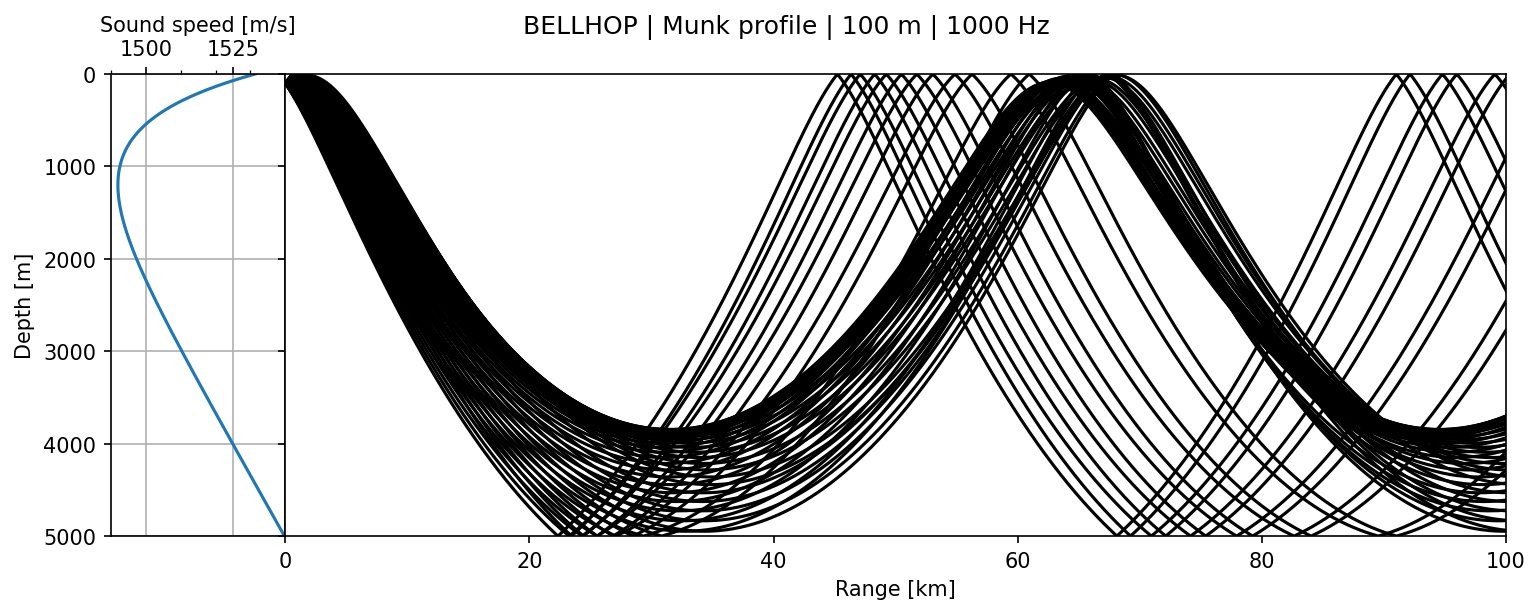

In [6]:
title = "Munk"

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

# top = Top(opt="CVF  I ")
top = Top()

ssp = SoundSpeedProfileAT(z=z_data, c_p=c_data)
layer = SSPLayer(ssp)
layers = [layer]

bottom = Bottom(opt="A", z=layer.z_max, c_p=1600, rho=1.8, a_p=0.8)

src_z = 100
source = Source(src_z)
zvec = np.arange(0, layer.z_max + 1, 10)
zvec = 1000
rvec = 100

receiver = Receiver(z=zvec, r=rvec)

fan = BeamFan(nbeams=51)
integrator = NumericalIntegrator(zbox=layer.z_max + 3, rbox=101)

freq = 1000

bellhop_env = BellhopEnvironment(
    title,
    freq,
    layers,
    top,
    bottom,
    tmpdir="tmp",
    source=source,
    receiver=receiver,
    fan=fan,
    integrator=integrator,
)

model = BellhopModel(bellhop_env)
model.run(keep_files=False)
beams = model.beams

fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 7], "wspace": 0},
    figsize=(12, 4),
    dpi=150,
    facecolor="w",
)
ax = plot_SSP(z_data, c_data, xlabel="Sound speed [m/s]", ylabel="Depth [m]", ax=axs[0])

ax = axs[1]
for ray in beams.sources[0]:
    ax.plot([r / 1000 for r in ray.r], ray.z, "k")
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_ylim(5000, 0)
ax.set_xlabel("Range [km]")
fig.suptitle(f"BELLHOP | {title} profile | {src_z} m | {freq} Hz")
plt.show()

### Plotting the eigenrays

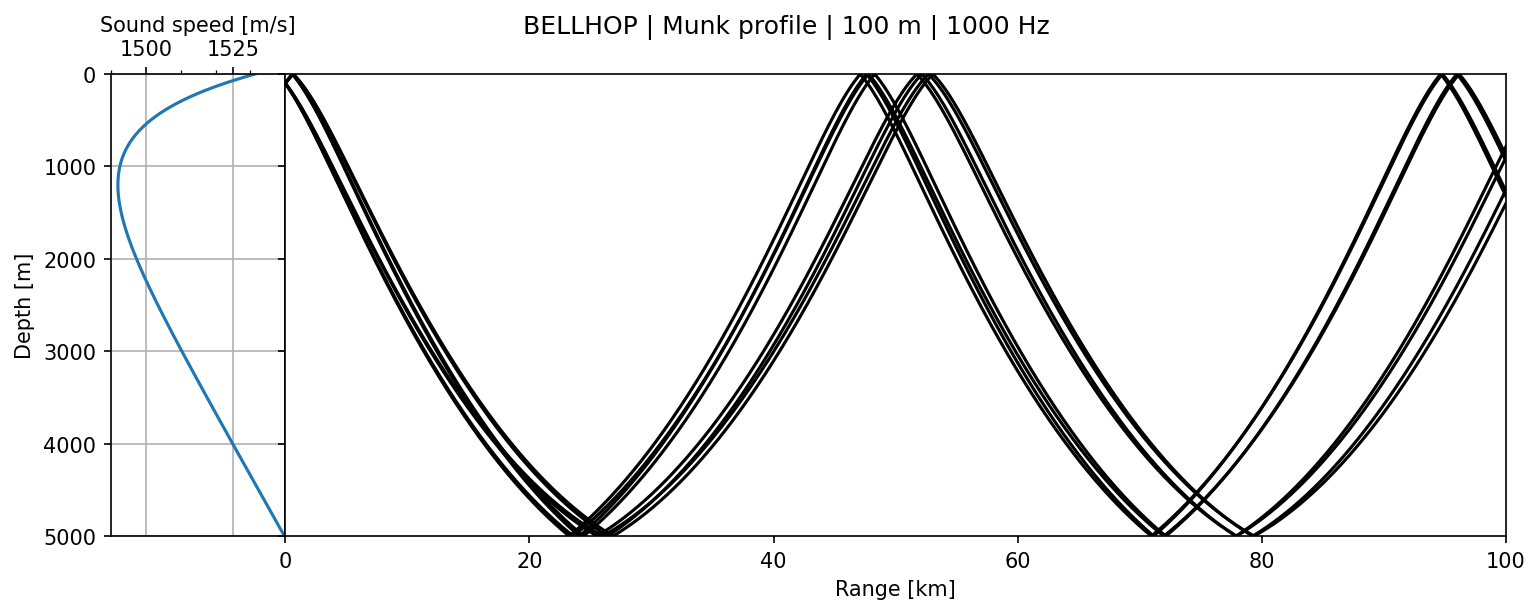

In [7]:
title = "Munk"

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

# top = Top(opt="CVF  I ")
top = Top()

ssp = SoundSpeedProfileAT(z=z_data, c_p=c_data)
layer = SSPLayer(ssp)
layers = [layer]

bottom = Bottom(opt="A", z=layer.z_max, c_p=1600, rho=1.8, a_p=0.8)

src_z = 100
source = Source(src_z)
zvec = np.arange(0, layer.z_max + 1, 10)
zvec = 1000
rvec = 100

receiver = Receiver(z=zvec, r=rvec)

# fan = BeamFan(isingle=5)
fan = BeamFan(nbeams=151)
integrator = NumericalIntegrator(zbox=layer.z_max + 3, rbox=101)
options = BellhopOptions(run_type="E")

freq = 1000

bellhop_env = BellhopEnvironment(
    title,
    freq,
    layers,
    top,
    bottom,
    tmpdir="tmp",
    source=source,
    receiver=receiver,
    options=options,
    fan=fan,
    integrator=integrator,
)

model = BellhopModel(bellhop_env)
model.run(keep_files=False)
beams = model.beams

fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 7], "wspace": 0},
    figsize=(12, 4),
    dpi=150,
    facecolor="w",
)
ax = plot_SSP(z_data, c_data, xlabel="Sound speed [m/s]", ylabel="Depth [m]", ax=axs[0])

ax = axs[1]
for ray in beams.sources[0]:
    ax.plot([r / 1000 for r in ray.r], ray.z, "k")
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_ylim(5000, 0)
ax.set_xlabel("Range [km]")
fig.suptitle(f"BELLHOP | {title} profile | {src_z} m | {freq} Hz")
plt.show()

### Plotting a single ray

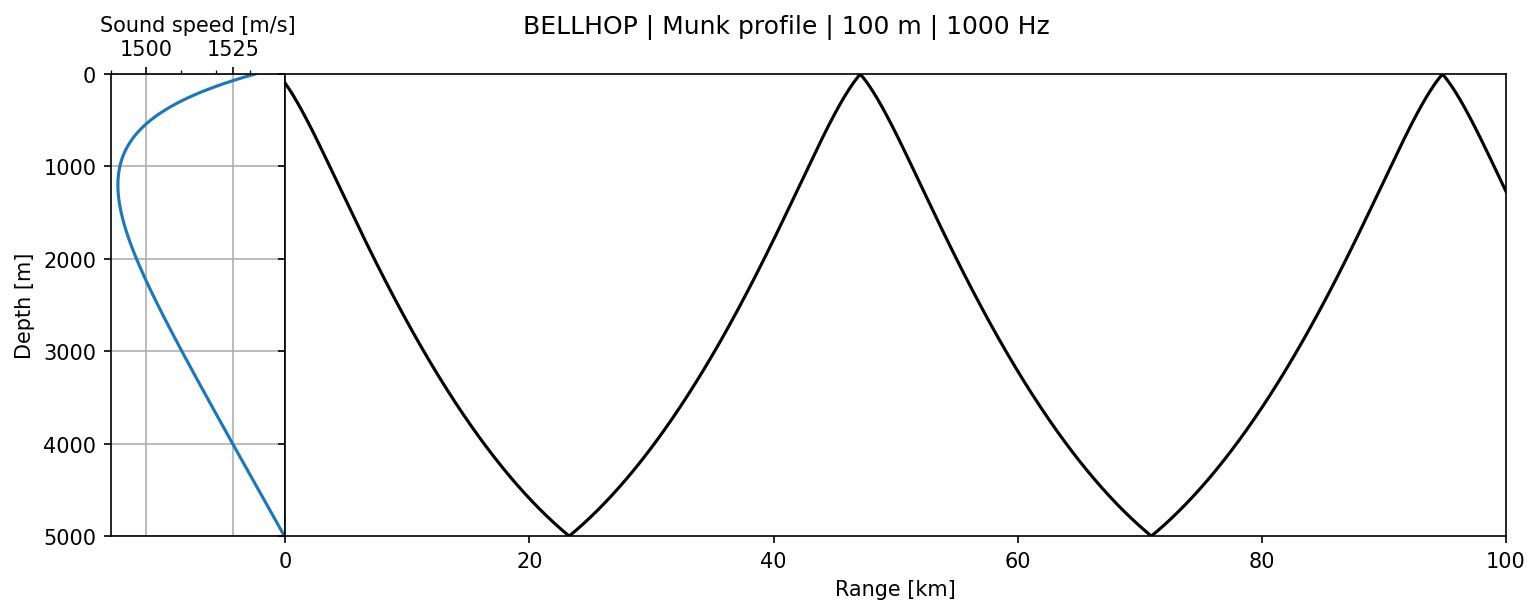

In [8]:
title = "Munk"

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

top = Top(opt="CVF  I ")

ssp = SoundSpeedProfileAT(z=z_data, c_p=c_data)
layer = SSPLayer(ssp)
layers = [layer]

bottom = Bottom(opt="A", z=layer.z_max, c_p=1600, rho=1.8, a_p=0.8)

src_z = 100
source = Source(src_z)
zvec = np.arange(0, layer.z_max + 1, 10)
zvec = 1000
rvec = 100
# rvec = np.arange(0, 100, 100 / 1e3)

receiver = Receiver(z=zvec, r=rvec)

fan = BeamFan(isingle=50)
integrator = NumericalIntegrator(zbox=layer.z_max + 3, rbox=101)

freq = 1000

bellhop_env = BellhopEnvironment(
    title,
    freq,
    layers,
    top,
    bottom,
    tmpdir="tmp",
    source=source,
    receiver=receiver,
    fan=fan,
    integrator=integrator,
)

model = BellhopModel(bellhop_env)
model.run(keep_files=False)
beams = model.beams

fig, axs = plt.subplots(
    1,
    2,
    sharey=True,
    gridspec_kw={"width_ratios": [1, 7], "wspace": 0},
    figsize=(12, 4),
    dpi=150,
    facecolor="w",
)
ax = plot_SSP(z_data, c_data, xlabel="Sound speed [m/s]", ylabel="Depth [m]", ax=axs[0])

ax = axs[1]
for ray in beams.sources[0]:
    ax.plot([r / 1000 for r in ray.r], ray.z, "k")
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_ylim(5000, 0)
ax.set_xlabel("Range [km]")
fig.suptitle(f"BELLHOP | {title} profile | {src_z} m | {freq} Hz")
plt.show()